# Segmenting ROI and RONI in CT scan
### Author- Anupreet Singh(UMBC Campus ID-UK43298)

In [1]:
## Setting up dependecies in the environment 
# %pip install opencv-python matplotlib 
import cv2
import numpy as np
import matplotlib.pyplot as plt

### TECH NOTE(OPEN CV)
1. When you read an image using open cv, it gets stored as a numpy array(2-D matrix in case of grayscale image)
2. The shape of image is (height, widht)
3. The X-axis(horizontal) and Y-axis(vertical) begin at the top left corner.<br> 
X-axis extends rightward and Y-axis extends downwards.<br>
Therefore, image[20, 30] refers to the 20th row (Y-axis) and the 30th column (X-axis) of the image, starting from the top-left corner.



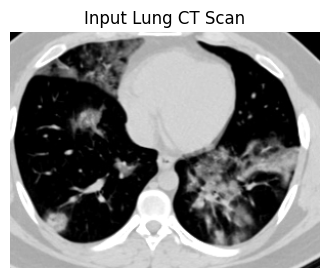

In [2]:
## Step 1 of 7: Loading an Image
# Path to the image file(Replace with the image path on your system)
image_path = "datasets/ctscan/raw/COVID/Covid (30).png"  

# Read the image in grayscale mode and store it as a NumPy array(where each element represents the pixel intensity stored as an 8 bit unsigned integer ranging from 0-255) in input_image
input_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if image was successfully loaded
if input_image is None:
    raise ValueError("Image not found or path is incorrect.")

# Displaying the image
plt.figure(figsize=(4, 4)) # Creates a new figure/ sets a canvas to draw on.
plt.imshow(input_image, cmap='gray') # Loads the image stored as numpy array in "input_image", using the grayscale colormap
plt.title("Input Lung CT Scan")#Adds Title above the image
plt.axis('off')# Hides the X and Y axis
plt.show()# Renders the figure for displaying in the notebook

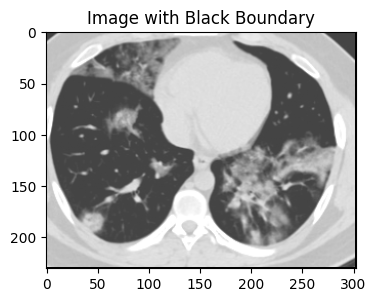

In [3]:
## Step 2 of 7: Drawing a black Boundary on the input image, in this case the black boundary is just at the edge of the of image
# Make a copy of the input image so we don't overwrite the original
image_boundary = input_image.copy()

# Drawing a black border (1 pixel wide) on all sides of the image by putting the intensity to 0(Black)
image_boundary[0, :] = 0             # Top row
image_boundary[-1, :] = 0            # Bottom row
image_boundary[:, 0] = 0             # Left most column
image_boundary[:, -1] = 0            # Right most column

# Display the image with the black boundary
plt.figure(figsize=(4, 4))
plt.imshow(image_boundary, cmap='gray')
plt.title("Image with Black Boundary")
# plt.axis('off')
plt.show()


Otsu's Threshold (Tfinal): 144.0


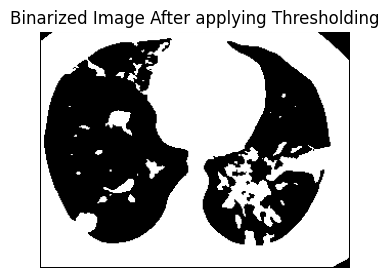

In [4]:
## Step 3 of 7: Use OpenCV's built-in Otsu's method to compute threshold & Step 4 of 7: Turn all pixels greater than T_final white to get binarized_image
# cv2.threshold returns both threshold and the binarized image
# All pixels > Tfinal → 255 (white), else → 0 (black)
T_final, binarized_image  = cv2.threshold(
    image_boundary,      # Input image (must be grayscale)
    0,             # Initial threshold value (ignored when using Otsu)
    255,           # Max value to use in binary thresholding
    cv2.THRESH_BINARY + cv2.THRESH_OTSU #Tells opencv to perform binary thresholding with otsu's method
)

print(f"Otsu's Threshold (Tfinal): {T_final}")

#Displaying the binarized result
plt.figure(figsize=(4, 4))
plt.imshow(binarized_image, cmap='gray')
plt.title("Binarized Image After applying Thresholding")
plt.axis('off')
plt.show()


In [5]:
## Step 5 of 7: Find the seed pixels
# The lungs are dark, and were kept black (0) after binarization.
#In each of the 4 Quadrants of the image, We're looking for the first black pixel — that’s your seed for that quadrant.

height, width = binarized_image.shape #Storing the height and width 
margin = 1 # Setting margin of 1 since edges are the black boundary itself(1st pixel), so we start from pixel on the inside edge of the black boundary

# Lines dividing the four quadrants
mid_row = height // 2
mid_col = width // 2

seeds = {} # making a dictionary to store the seeds for each quadrant

# Quadrant 1: Upper-left (start from left edge of center row of Quadrant 1, move right)
row_q1 = height // 4 
for x in range(margin, mid_col):
    if binarized_image[row_q1, x] == 0:# The first black pixel we encounter
        seeds['upper_left'] = (row_q1, x)# storing the seed
        print("Upper-left seed:", seeds['upper_left'])# Printing the seed
        break

# Quadrant 2: Lower-left (start from left edge of center row of Quadrant 2, move right)
row_q2 = 3 * height // 4
for x in range(margin, mid_col):
    if binarized_image[row_q2, x] == 0:
        seeds['lower_left'] = (row_q2, x)# storing the seed
        print("Lower-left seed:", seeds['lower_left'])# Printing the seed
        break

# Quadrant 3: Upper-right (start from right edge of center row of Quadrant 3, move left)
row_q3 = height // 4
for x in range(width - 1 - margin, mid_col, -1):
    if binarized_image[row_q3, x] == 0:# The first black pixel we encounter
        seeds['upper_right'] = (row_q3, x)# storing the seed
        print("Upper-right seed:", seeds['upper_right'])# Printing the seed
        break

# Quadrant 4: Lower-right (start from right edge of center row of Quadrant 4, move left)
row_q4 = 3 * height // 4
for x in range(width - 1 - margin, mid_col, -1):
    if binarized_image[row_q4, x] == 0:# The first black pixel we encounter
        seeds['lower_right'] = (row_q4, x)# storing the seed
        print("Lower-right seed:", seeds['lower_right'])# Printing the seed
        break




Upper-left seed: (57, 15)
Lower-left seed: (173, 25)
Upper-right seed: (57, 270)
Lower-right seed: (173, 262)


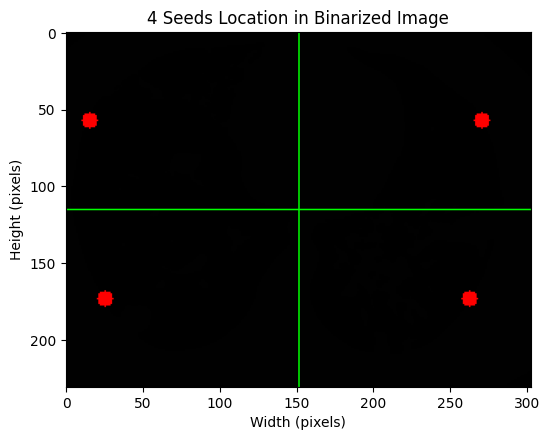

In [6]:
## Printing the 4-Quadrant Image with seeds
import cv2
import matplotlib.pyplot as plt

# Assuming binarized_image and seeds dictionary already exist

# Convert image to RGB so we can draw colored markers
image_rgb = cv2.cvtColor(binarized_image * 255, cv2.COLOR_GRAY2RGB)

# Draw a red dot at each seed
for key, (row, col) in seeds.items():
    cv2.circle(image_rgb, (col, row), radius=5, color=(255, 0, 0), thickness=-1)

# Draw lines to split into 4 quadrants
height, width = binarized_image.shape
mid_row = height // 2
mid_col = width // 2
cv2.line(image_rgb, (0, mid_row), (width, mid_row), color=(0, 255, 0), thickness=1)
cv2.line(image_rgb, (mid_col, 0), (mid_col, height), color=(0, 255, 0), thickness=1)

# Plot with axes ON
plt.figure(figsize=(6, 6))
plt.imshow(image_rgb)
plt.title("4 Seeds Location in Binarized Image")
plt.axis('on')  # Show axis
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.grid(False)
plt.show()


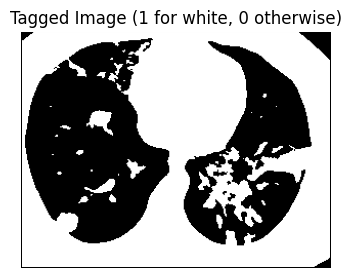

In [7]:
## Step 6: Creating a tagged image
"""
Syntax: np.where(condition, value_if_true, value_if_false)
np.where automatically checks the given condition for each element of the numpy array, and return a new array with updated values according to the conditions
Then .astype converts values of the return numpy array from integers to 8-bit unsigned integers(which is the standard usage for grayscale images)
"""
tagged_image = np.where(binarized_image == 255, 1, 0).astype(np.uint8)

plt.figure(figsize=(4, 4))
plt.imshow(tagged_image, cmap='gray')
plt.title("Tagged Image (1 for white, 0 otherwise)")
plt.axis('off')
plt.show()

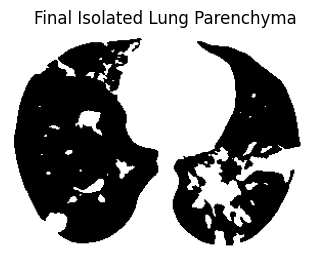

In [8]:
## Step 7 of 7: Growing region from Seeds
# Basically starts at a seed and expands to make the successive neighbours black, which were black in the tagged_image

# Make a white copy of the image to draw the lungs on basically
result_image = np.ones_like(binarized_image, dtype=np.uint8) * 255

# Mask to keep track of visited pixels
visited = np.zeros_like(tagged_image, dtype=bool)

# 4-connected neighbor directions(above, below, left, right)
neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]

from collections import deque # importing deque for BFS basically 

# Loop through all 4 quadrant seeds
for seed_name in seeds:  # seeds is a dict with 4 quadrant seeds
    seed = seeds[seed_name]#seeds stores the location of the seeds for that quadrant
    if not visited[seed]:  # In case overlapping regions exist, we check if the current seeds has been visited in some other quadrants region expansion
        queue = deque([seed])# initialize the double ended queue with the seed
        visited[seed] = True # Mark the seed as True in the visited mask

        while queue:# Goes until the queue is empty
            y, x = queue.popleft()# retrieves the element from the begining of the queue
            result_image[y, x] = 0# Makes the element black

            for dy, dx in neighbors:#Iterates over 4 neighbours of the currently popped element
                ny, nx = y + dy, x + dx# Location of current neighbour 
                if (0 <= ny < result_image.shape[0]) and (0 <= nx < result_image.shape[1]): #Just a bound check to make sure the current location is inside the picture
                    if not visited[ny, nx] and tagged_image[ny, nx] == 0:# Checks that this neighbour/pixel hasn't been visited and it was black in the tagged/binarized image
                        queue.append((ny, nx))# Adds neighbour to the queue for its successive neighbour checks and making it black in the result_image
                        visited[ny, nx] = True# sets the neighbour as True in the visited mask

# Display the result
plt.figure(figsize=(4, 4))
plt.imshow(result_image, cmap='gray')
plt.title("Final Isolated Lung Parenchyma")
plt.axis('off')
plt.savefig("Covid ROI-(30).png", bbox_inches='tight')
plt.show()




# Emedding the Watermark in the RONI
Author- Anupreet Singh, Campus ID-UK43298

### **Steps in Embedding the Watermark into the Image**

1. **Compute Hash/Watermark** 
   - Read the grayscale medical image  
   - Set LSBs of all pixels to `0` (create a modified image) 
   - Apply a cryptographic hash function (e.g., **SHA-512**) on the modified image to get a **128-character hexadecimal string**  
   - Each of the 128 hexadecimal characters is treated as a regular character and converted to its **ASCII value** (which requires **8 binary bits** to represent), so final binary representation has length **128 × 8 = 1024**

2. **Scramble RONI Pixels**  
   - From **RONI coordinates** retrieved from `result_image`, get **intensity values** for those pixels in the **original image**  
   - **Scramble/Shuffle** intensity values of the RONI pixels in the original image

3. **Embed Watermark in Scrambled RONI**  
   - Embed **hash output directly** or **BCH encoded hash output** in the **LSBs** of scrambled RONI pixels

4. **Unscramble RONI and Display Final Watermarked Image**  
   - Reverse the scrambling to return **RONI to original spatial layout**
   - Output the Final Watermarked Image

---
**Another Thing that could be done at the end of Step 1 is Apply BCH Encoding:**
   - Encode the **1024-bit sequence** using a **BCH encoder**  
   - Resulting length depends on BCH parameters (e.g., **511 bits** for **BCH(511, 256**)  
   - This produces the **error-tolerant watermark `w3_encoded`**


### **Reason for Scrambling**

For one input image, say we have segmented the image into **ROI** and **RONI**.  
We will always select the **first 256 coordinates from the RONI list**.

---

**_IF we don't scramble:_**  
We always embed the watermark into the original pixel values of those **first 256 coordinates**.

---

**_If we do scramble and then unscramble:_**  
Those first 256 coordinates hold values from some other RONI coordinates selected at _"random"_ from the RONI list depending on our **key**.  
We now embed the watermark into **these values**.  
Then **rescrambling** takes these values to their **original RONI coordinates**.  
The values hold the **watermark**.  
Now, **only if we know the key for scrambling**, can we know the values whose **LSBs** have the watermark embedded in them.


In [9]:
## Setting up dependencies
!pip install bitarray
!pip install bchlib
!pip install scikit-image

import hashlib
import bchlib
import binascii
from bitarray import bitarray
from skimage.metrics import structural_similarity


### TECH NOTE(BCH Encoding)
1. Message Length(k): k is the number of message bits that are input to the BCH encoder. It represents the "original" data you want to protect (the data bits before encoding)
2. Codeword Length(n): n is the length of the resulting encoded data after the BCH encoding. This includes both the original k bits of the message and the redundant parity bits used for error detection and correction. 
3. Error Correction(n-k): The extra bits (n - k) in the BCH code are parity bits used for error detection and correction. These redundant bits help in correcting errors that might occur during transmission or storage(compression, noise, bit loss, etc).

In [10]:
## Step 1
# Setting LSBs of all pixels to zero
lsb_zeroed_image = input_image.copy()  # creating a copy of the input_image loaded in the beginning
lsb_zeroed_image = lsb_zeroed_image & 0b11111110  # Mask LSB to 0,  & 0b11111110 performs Bitwise AND operator between each element of the numpy array and 0b11111110, essentially setting last digit of each element to zero

#Flattening the image into a byte stream sutiable for hashing
flattened_bytes = lsb_zeroed_image.flatten().tobytes()#.flatten converts the 2D array to 1D array, /tobytes() converts all elements from int to byte form(1 byte can store upto 8 bits(255) info)

#Computing SHA-512 hash as 128 character hexadecimal sequence(SHA-512 hash gives 512-bit = 128(512/4) hex characters)
hash_hex = hashlib.sha512(flattened_bytes).hexdigest()  # hexdigest gives the output a hexadecimal representation

#Converting the hex sequence to ASCII value in binary to get the watermark
"""
for char in hash_hex iterates over each element of the sequence
ord() converts character to ASCII value(integer)
f'{56:08b}' is a formatted string that converts 56 to 8 bits binary format
.join() concatenates all these values into one
"""
binary_representation = ''.join(f'{ord(char):08b}' for char in hash_hex)  

#Printing the output
print(f"SHA-512 Hash Output(Hexadecimal): {hash_hex}")
print(f"Binary Representation of SHA-512 Hash: {binary_representation}")
print(f"The length of the binary representation is: {len(binary_representation)}")



SHA-512 Hash Output(Hexadecimal): a32161e8570170ce7c4b8e6c5eee4c4165086dadd79d36ee907036e0f3f087fe1bd24f69227238f3be1ca578a5d182a02704d0966a8370bcbfe7d4a1c06531ae
Binary Representation of SHA-512 Hash: 011000010011001100110010001100010011011000110001011001010011100000110101001101110011000000110001001101110011000001100011011001010011011101100011001101000110001000111000011001010011011001100011001101010110010101100101011001010011010001100011001101000011000100110110001101010011000000111000001101100110010001100001011001000110010000110111001110010110010000110011001101100110010101100101001110010011000000110111001100000011001100110110011001010011000001100110001100110110011000110000001110000011011101100110011001010011000101100010011001000011001000110100011001100011011000111001001100100011001000110111001100100011001100111000011001100011001101100010011001010011000101100011011000010011010100110111001110000110000100110101011001000011000100111000001100100110000100110000001100100011011100110000001101

Number of RONI pixels: 41185


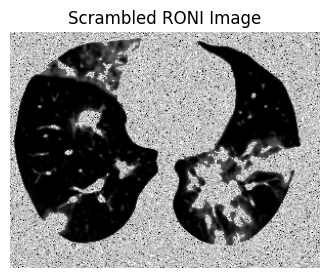

In [11]:
## Step 2: Srambling the identified RONI pixels in the original Image

# Define the key (seed value) for reproducibility
key = 42  # You can change this value to any integer, Ideally even this should be made using a PRNG

# Basically we are fixing the seed used by np.random() function as "key"
np.random.seed(key)

# Making a copy of the original image to scramble
scrambled_image = input_image.copy()

# result_image is the final ROI and RONI separated image. 
# Extracting coordinates of RONI pixels (value = 255)
roni_coords = np.column_stack(np.where(result_image == 255)) # 2D array where each row represents a coordinate or pixel value=255
"""
np.where(result_image==255) returns Two 1D arrays 
First Array with row indices of all pixels with value 255
Second Array with corresponding column indices of all pixels with value 255
np.column_stack() takes in 1D array and returns a 2D array where each input 1D array is stacked as a column
This 2D array will be of shape(N,2)
"""

# Extract the pixel values at those RONI positions in input_image
roni_values = input_image[roni_coords[:, 0], roni_coords[:, 1]]
"""
roni_coords[:,0] means from all rows of roni_coords, retrieve the first element(X-coordinate)
roni_coords[:,1] means from all rows of roni_coords, retrieve the second element(Y-coordinate)
numpy arrays used advanced indexing, so when you pass two 1D arrays of same length, NumPy pairs corresponding elements, and returns a list 
So input_image[[1, 4, 8], [2, 4, 3]] is loaded as [
  input_image[1, 2], 
  input_image[4, 4], 
  input_image[8, 3], 
]
Giving us a list of intensity values of RONI pixels
"""

# Shuffles the order of intensity values of RONI pixels stored in roni_values in place
np.random.shuffle(roni_values)

# Reassign shuffled values back to all RONI positions
scrambled_image[roni_coords[:, 0], roni_coords[:, 1]] = roni_values

print(f"Number of RONI pixels: {len(roni_coords)}")
# Display the result
plt.figure(figsize=(4, 4))
plt.imshow(scrambled_image, cmap='gray')
plt.title("Scrambled RONI Image")
plt.axis('off')
plt.savefig("Covid RONI-Scrambled-Key.png", bbox_inches='tight')
plt.show()



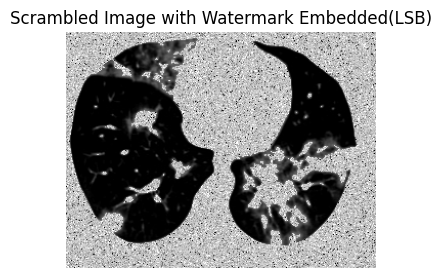

In [12]:
## Step 3: Embed Watermark in Scrambled RONI

# In case BCH does not work out, we consider the binary hash as the watermark to be embedded
bin_watermark = binary_representation

# Ensure the watermark to be embedded is 1024 bits (from BCH encoding or direct hash)
assert len(bin_watermark) == 1024, "Error: Watermark to be embedded must be 256 bits."

# Convert the watermark binary string to a list of integers (0s and 1s)
watermark_bits = [int(bit) for bit in bin_watermark]

# Check the number of total available RONI pixels
num_roni_pixels = len(roni_coords)

# Sanity check: Ensure there's at least one RONI pixel
if num_roni_pixels == 0:
    raise ValueError("No RONI pixels available for embedding.")

WM_coords = roni_coords[:1024]# Selecting the first 1024 rows of coordinates from the RONI coordinates list to embed the watermark into

# Embed the watermark bits in the LSBs of the selected RONI pixels of scrambled_image
for idx, bit in enumerate(watermark_bits):
    roni_x, roni_y = WM_coords[idx]# Each row of WM_coords would give us x and y coordinate of the RONI pixel we want to embed the watermark into 
    pixel_value = scrambled_image[roni_x, roni_y]# Retrieve the pixel value of the Watermark Coordinate

    # Modify the LSB
    new_pixel_value = (pixel_value | 1) if bit == 1 else (pixel_value & 0xFE)# If the bit to be embedded is 1, 
    """
    pixel_value is an int ranging from 0-255(grayscale image boundary)
    If bit ==1, When we apply bitwise OR operator( | ), 
    let us say pixel_value= 154, it is converted to binary (10011010) and 1 is also converted to binary (00000001)
    So the LSB of pixel is forced to be 1, and the pixel value is updated 

    If bit==0, When we apply bitwise AND operator( & )
    let us say pixel_value= 154, it is converted to binary (10011010) and 0xFE in binary: 11111110)
    So the LSB of pixel is forced to be 0, and the pixel value is updated 
    """
    scrambled_image[roni_x, roni_y] = new_pixel_value

# Display the result with the embedded watermark
plt.figure(figsize=(4, 4))
plt.imshow(scrambled_image, cmap='gray')
plt.title("Scrambled Image with Watermark Embedded(LSB)")
plt.axis('off')
plt.show()

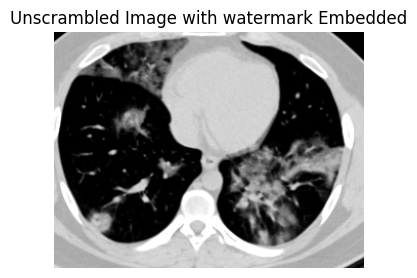

In [13]:
## Step 4: Unscramble the pixels in RONI to take them back to original position, and display final Watermarked image

# The key used is the same but we need to Re-seed to the RNG of Numpy to the bring it to the same state as it was when shuffling/scrambling the roni_coords
np.random.seed(key)

# Making Index array for helping with getting original order back
original_indices = np.arange(num_roni_pixels) #np.arange() give a numpy array with values ranging form 0 to num_roni_pixels-1
shuffled_indices = original_indices.copy() #making copy to shuffling 
np.random.shuffle(shuffled_indices) # Shuffled

# Computing inverse permutation using argsort
reverse_indices = np.argsort(shuffled_indices)# np.argsort() gives an array of indices corresponding to values of shuffled_indices that would result in an ascending/sorted order

# At this point RONI coordinates in scrambled_image has their values shuffled and then watermark embedded in the first 256 elements in the roni_coordinates list 
# Extracting RONI values from the scrambled image
embedded_roni_values = scrambled_image[roni_coords[:, 0], roni_coords[:, 1]]

# Restoring order of values roni_values as it were before shuffling
descrambled_values = embedded_roni_values[reverse_indices]

# Assigning descrambled values to RONI coordinates in the image 
scrambled_image[roni_coords[:, 0], roni_coords[:, 1]] = descrambled_values

# Display the result with the embedded watermark
plt.figure(figsize=(4, 4))
plt.imshow(scrambled_image, cmap='gray')
plt.title("Unscrambled Image with watermark Embedded")
plt.axis('off')
plt.show()


In [14]:
## Commented out Sample Code for shuflfing and unshuffling a numpy array
"""
data = np.array([10, 20, 30, 40, 50,74, 83,97,26])
print("Original data:", data)
key = 55

# Shuffle step
np.random.seed(key)
shuffled = data.copy()
np.random.shuffle(shuffled)
print("Shuffled:", shuffled)

# Reshuffle (reverse) step — resetting seed to ensure same shuffle order
# np.random.seed(key)
# Get original shuffle indices
indices = np.arange(len(data)) #np.arange() creates a numpy array with values ranging from 0 to len(data)-1
np.random.shuffle(indices) #shuffling the indices, with the same key would put them in the same position as the value in data array 

# Create reverse mapping
reverse_indices = np.argsort(indices)# np.argsort() returns an array of indices of the elements from shuffled_indices that correspond to  sorted/ascending order
#indices[reverse_indices] would give the the sorted form which is also the original form of indices
# Similarly shuffled[reverse_indices] would also give the original form of shuffled. 
restored = shuffled[reverse_indices]
print("Restored:", restored)
"""

'\ndata = np.array([10, 20, 30, 40, 50,74, 83,97,26])\nprint("Original data:", data)\nkey = 55\n\n# Shuffle step\nnp.random.seed(key)\nshuffled = data.copy()\nnp.random.shuffle(shuffled)\nprint("Shuffled:", shuffled)\n\n# Reshuffle (reverse) step — resetting seed to ensure same shuffle order\n# np.random.seed(key)\n# Get original shuffle indices\nindices = np.arange(len(data)) #np.arange() creates a numpy array with values ranging from 0 to len(data)-1\nnp.random.shuffle(indices) #shuffling the indices, with the same key would put them in the same position as the value in data array \n\n# Create reverse mapping\nreverse_indices = np.argsort(indices)# np.argsort() returns an array of indices of the elements from shuffled_indices that correspond to  sorted/ascending order\n#indices[reverse_indices] would give the the sorted form which is also the original form of indices\n# Similarly shuffled[reverse_indices] would also give the original form of shuffled. \nrestored = shuffled[reverse_in

In [15]:
## Sanity Check of Structural Similarity to see that the watermark has been embedded
ssim = structural_similarity(input_image, scrambled_image, data_range=scrambled_image.max() - scrambled_image.min())
print(ssim)


0.9999062845732953


# Extracting Watermark from Image for Content Authentication

### Steps for Extraction and Hash Verification(Not written code for this since it isn't relevant for Image Analysis): 

1. **Extract the Watermark**  
  - Load the grayscale medical image that contains the embedded watermark.
  - Identify the ROI and RONI segments
  - Scramble the pixels of RONI using the same key used for embedding.
  - Retrieve the LSBs of the relevant pixels (first 256 in the list of `roni_coords` in our case ) to extract the **256-bit binary watermark**.

2. **Recompute the Hash from Image Content**  
  - Set all LSBs of the image pixels to `0`.  
  - Apply the same cryptographic hash function (e.g., **SHA-512**) to the modified image to generate a **256-bit binary sequence**.

3. **Compare the Hash and Extracted Watermark**  
  - Compare the extracted watermark bits recomputed binary hash.

4. **Verify Image Integrity**  
  - If the two sequences match: **Image is authentic** and has not been tampered with.  
  - If they differ: **Tampering or re-watermarking is detected**.

